
WQI Class Distribution:
WQI_Class
Good          1172
Unsuitable     598
Poor           221
Name: count, dtype: int64

Random Forest Classifier Performance (Manual Calculation):
Accuracy: 97.99%
Precision (macro): 0.9675
Recall (macro): 0.9595
F1 Score (macro): 0.9634
ROC AUC Score: 0.9981

Classification Report (sklearn):
              precision    recall  f1-score   support

        Good       0.99      1.00      0.99       231
        Poor       0.93      0.91      0.92        45
  Unsuitable       0.98      0.97      0.98       123

    accuracy                           0.98       399
   macro avg       0.97      0.96      0.96       399
weighted avg       0.98      0.98      0.98       399


Confusion Matrix:
[[231   0   0]
 [  2  41   2]
 [  1   3 119]]


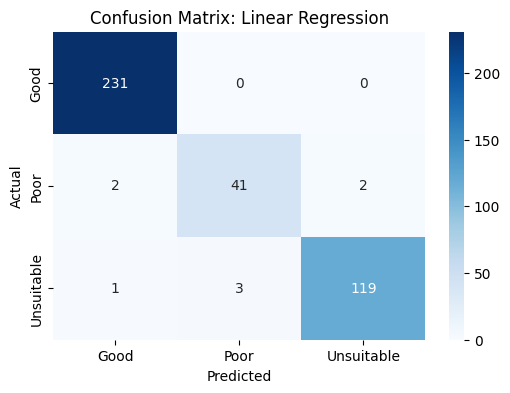

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score)
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Loading the dataset
file_path = "water_dataX.csv"
df = pd.read_csv(file_path, encoding='latin1')

# Renaming columns
df.rename(columns={
    'D.O. (mg/l)': 'Dissolved_Oxygen',
    'PH': 'pH',
    'CONDUCTIVITY (µmhos/cm)': 'Conductivity',
    'B.O.D. (mg/l)': 'Biological_Oxygen',
    'NITRATENAN N+ NITRITENANN (mg/l)': 'Nitrate',
    'FECAL COLIFORM (MPN/100ml)': 'Fecal_Coliform',
    'TOTAL COLIFORM (MPN/100ml)Mean': 'Total_Coliform'
}, inplace=True)

# Converting numeric columns
numeric_columns = ['Dissolved_Oxygen', 'pH', 'Conductivity', 'Biological_Oxygen', 'Nitrate', 'Fecal_Coliform', 'Total_Coliform']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Standards
standards = {
    'Dissolved_Oxygen': (14.6, 6),
    'pH': (8.5, 7),
    'Conductivity': (300, 0),
    'Biological_Oxygen': (5, 0),
    'Nitrate': (45, 0),
    'Fecal_Coliform': (500, 0),
    'Total_Coliform': (1000, 0)
}
weights = {param: 1/std[0] for param, std in standards.items()}

#WQI calculation

def compute_qi(value, param):
    si, vid = standards[param]
    return ((value - vid) / (si - vid)) * 100 if pd.notna(value) else 0

df['WQI'] = df.apply(lambda row: sum(compute_qi(row[param], param) * weights[param] for param in standards.keys()) / sum(weights.values()), axis=1)

# WQI classification
def classify_wqi(wqi):
    if wqi <= 50:
        return "Good"
    elif 51 <= wqi <= 100:
        return "Poor"
    else:
        return "Unsuitable"

df['WQI_Class'] = df['WQI'].apply(classify_wqi)

# WQI Class Distribution
print("\nWQI Class Distribution:")
print(df['WQI_Class'].value_counts())

# Prepare classification
X = df[numeric_columns]
y_class = df['WQI_Class']

le = LabelEncoder()
y_encoded = le.fit_transform(y_class)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Linear Regression
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Manual Metric Calculation based on confusion matrix
n_classes = conf_matrix.shape[0]
TP = np.diag(conf_matrix)
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (TP + FP + FN)

# Precision, Recall, F1 for each class
precision_per_class = TP / (TP + FP)
recall_per_class = TP / (TP + FN)
f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)

# Handling division by zero
precision_per_class = np.nan_to_num(precision_per_class)
recall_per_class = np.nan_to_num(recall_per_class)
f1_per_class = np.nan_to_num(f1_per_class)

# Macro-averaged metrics
precision_macro = precision_per_class.mean()
recall_macro = recall_per_class.mean()
f1_macro = f1_per_class.mean()

# Accuracy
accuracy = (TP.sum()) / conf_matrix.sum()

# ROC AUC (using sklearn because manual ROC AUC is very complicated for multi-class)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

# Output results
print("\nRandom Forest Classifier Performance (Manual Calculation):")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall (macro): {recall_macro:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

print("\nClassification Report (sklearn):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("\nConfusion Matrix:")
print(conf_matrix)

# Confusion Matrix Plot
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Linear Regression')
plt.show()



Random Forest Classifier Model Performance (Manual Calculation):
Accuracy: 97.99%
Precision (macro): 0.9675
Recall (macro): 0.9595
F1 Score (macro): 0.9634
ROC AUC Score: 0.9981

Classification Report (sklearn):
               precision    recall  f1-score   support

        Good       0.99      1.00      0.99       231
        Poor       0.93      0.91      0.92        45
  Unsuitable       0.98      0.97      0.98       123

    accuracy                           0.98       399
   macro avg       0.97      0.96      0.96       399
weighted avg       0.98      0.98      0.98       399



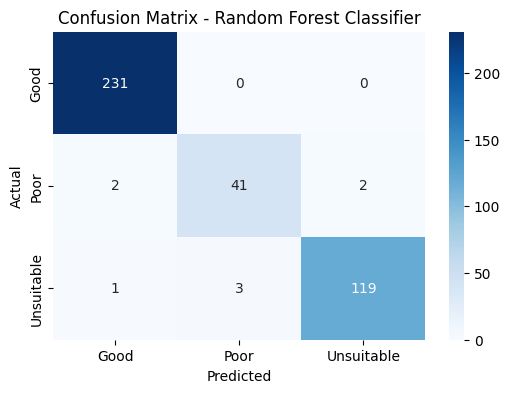

In [ ]:
# RANDOM FOREST MODEL

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Feature matrix and label encoding
X = df[['Dissolved_Oxygen', 'pH', 'Conductivity', 'Biological_Oxygen', 'Nitrate', 'Fecal_Coliform', 'Total_Coliform']]
y = df['WQI_Class'].astype('category')
y_encoded = y.cat.codes
label_names = y.cat.categories.tolist()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Predictions
y_pred = rf_clf.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Manual Metric Calculation
n_classes = conf_matrix.shape[0]
TP = np.diag(conf_matrix)
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (TP + FP + FN)

# Precision, Recall, F1 for each class
precision_per_class = TP / (TP + FP)
recall_per_class = TP / (TP + FN)
f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)

# Handle division by zero
precision_per_class = np.nan_to_num(precision_per_class)
recall_per_class = np.nan_to_num(recall_per_class)
f1_per_class = np.nan_to_num(f1_per_class)

# Macro averages
precision_macro = precision_per_class.mean()
recall_macro = recall_per_class.mean()
f1_macro = f1_per_class.mean()

# Accuracy
accuracy = (TP.sum()) / conf_matrix.sum()

# ROC AUC Score (for multi-class)
y_pred_proba = rf_clf.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

# Classification Report (optional detailed view)
report = classification_report(y_test, y_pred, target_names=label_names, zero_division=1)

# Print Evaluation Metrics
print(f"\nRandom Forest Classifier Model Performance (Manual Calculation):")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall (macro): {recall_macro:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

print("\nClassification Report (sklearn):\n", report)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()



XGBoost Classifier Model Performance (Manual Calculation):
Accuracy: 97.74%
Precision (macro): 0.9703
Recall (macro): 0.9521
F1 Score (macro): 0.9608
ROC AUC Score: 0.9987

Classification Report (sklearn):
               precision    recall  f1-score   support

        Good       0.98      1.00      0.99       231
        Poor       0.95      0.89      0.92        45
  Unsuitable       0.98      0.97      0.97       123

    accuracy                           0.98       399
   macro avg       0.97      0.95      0.96       399
weighted avg       0.98      0.98      0.98       399



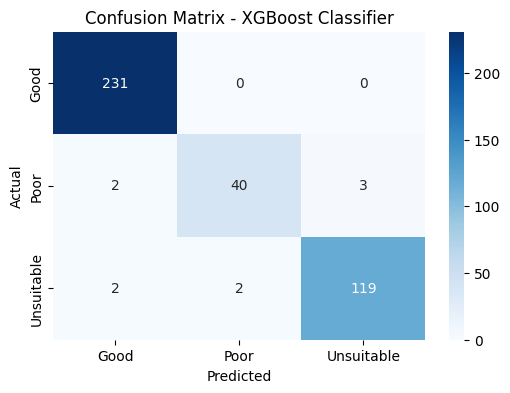

In [ ]:
# XGBOOST MODEL

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

# Suppress specific warning from XGBoost
warnings.filterwarnings("ignore", category=UserWarning, message=".*use_label_encoder.*")

# Feature matrix and label encoding
X = df[['Dissolved_Oxygen', 'pH', 'Conductivity', 'Biological_Oxygen', 'Nitrate', 'Fecal_Coliform', 'Total_Coliform']]
y = df['WQI_Class'].astype('category')
y_encoded = y.cat.codes
label_names = y.cat.categories.tolist()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# XGBoost Classifier
xgb_clf = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train, y_train)

# Predictions
y_pred = xgb_clf.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Manual Metric Calculation
n_classes = conf_matrix.shape[0]
TP = np.diag(conf_matrix)
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (TP + FP + FN)

# Precision, Recall, F1 for each class
precision_per_class = TP / (TP + FP)
recall_per_class = TP / (TP + FN)
f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)

# Handle division by zero
precision_per_class = np.nan_to_num(precision_per_class)
recall_per_class = np.nan_to_num(recall_per_class)
f1_per_class = np.nan_to_num(f1_per_class)

# Macro averages
precision_macro = precision_per_class.mean()
recall_macro = recall_per_class.mean()
f1_macro = f1_per_class.mean()

# Accuracy
accuracy = (TP.sum()) / conf_matrix.sum()

# ROC AUC Score (for multi-class)
y_pred_proba = xgb_clf.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

# Classification Report
report = classification_report(y_test, y_pred, target_names=label_names, zero_division=1)

# Print Evaluation Metrics
print("\nXGBoost Classifier Model Performance (Manual Calculation):")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall (macro): {recall_macro:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

print("\nClassification Report (sklearn):\n", report)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost Classifier')
plt.show()



Decision Tree Classifier Model Performance (Manual Calculation):
Accuracy: 96.24%
Precision (macro): 0.9340
Recall (macro): 0.9362
F1 Score (macro): 0.9351

Classification Report (sklearn):
               precision    recall  f1-score   support

        Good       0.99      0.98      0.99       231
        Poor       0.87      0.87      0.87        45
  Unsuitable       0.94      0.96      0.95       123

    accuracy                           0.96       399
   macro avg       0.93      0.94      0.94       399
weighted avg       0.96      0.96      0.96       399



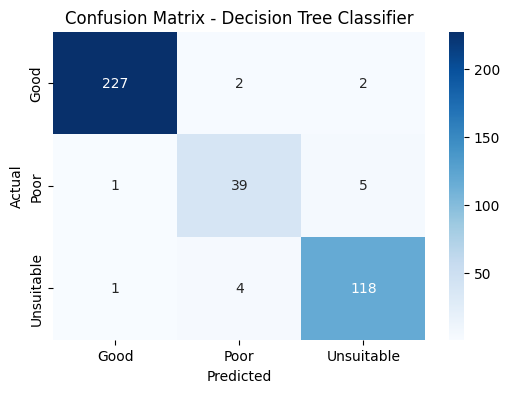

In [ ]:
# DECISION TREE MODEL

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Feature matrix and label encoding
X = df[['Dissolved_Oxygen', 'pH', 'Conductivity', 'Biological_Oxygen', 'Nitrate', 'Fecal_Coliform', 'Total_Coliform']]
y = df['WQI_Class'].astype('category')
y_encoded = y.cat.codes
label_names = y.cat.categories.tolist()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

# Predictions
y_pred = dt_clf.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Manual Metric Calculation
n_classes = conf_matrix.shape[0]
TP = np.diag(conf_matrix)
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (TP + FP + FN)

# Precision, Recall, F1 for each class
precision_per_class = TP / (TP + FP)
recall_per_class = TP / (TP + FN)
f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)

# Handle division by zero
precision_per_class = np.nan_to_num(precision_per_class)
recall_per_class = np.nan_to_num(recall_per_class)
f1_per_class = np.nan_to_num(f1_per_class)

# Macro averages
precision_macro = precision_per_class.mean()
recall_macro = recall_per_class.mean()
f1_macro = f1_per_class.mean()

# Overall Accuracy
accuracy = (TP.sum()) / conf_matrix.sum()

# Classification Report (for optional verification)
report = classification_report(y_test, y_pred, target_names=label_names, zero_division=1)

# Print Evaluation Metrics
print("\nDecision Tree Classifier Model Performance (Manual Calculation):")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall (macro): {recall_macro:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")

print("\nClassification Report (sklearn):\n", report)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree Classifier')
plt.show()



Naive Bayes Classifier Model Performance (Manual Calculation):
Accuracy: 80.45%
Precision (macro): 0.7316
Recall (macro): 0.6741
F1 Score (macro): 0.6859

Classification Report (sklearn):
               precision    recall  f1-score   support

        Good       0.84      0.97      0.90       231
        Poor       0.36      0.42      0.39        45
  Unsuitable       1.00      0.63      0.77       123

    accuracy                           0.80       399
   macro avg       0.73      0.67      0.69       399
weighted avg       0.83      0.80      0.80       399



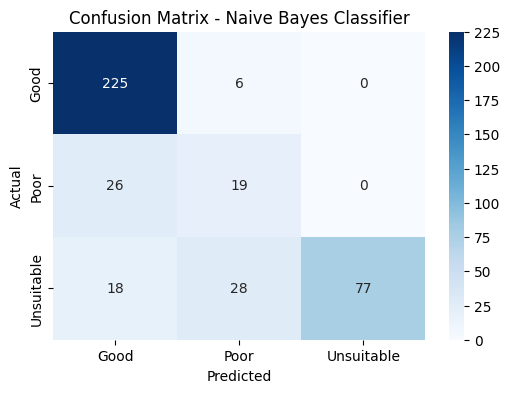

In [ ]:
# NAIVE BAYES MODEL

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Feature matrix and label encoding
X = df[['Dissolved_Oxygen', 'pH', 'Conductivity', 'Biological_Oxygen', 'Nitrate', 'Fecal_Coliform', 'Total_Coliform']]
y = df['WQI_Class'].astype('category')
y_encoded = y.cat.codes
label_names = y.cat.categories.tolist()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Naive Bayes Classifier
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)

# Predictions
y_pred = nb_clf.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Manual Metric Calculation
n_classes = conf_matrix.shape[0]
TP = np.diag(conf_matrix)
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (TP + FP + FN)

# Precision, Recall, F1 for each class
precision_per_class = TP / (TP + FP)
recall_per_class = TP / (TP + FN)
f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)

# Handle division by zero
precision_per_class = np.nan_to_num(precision_per_class)
recall_per_class = np.nan_to_num(recall_per_class)
f1_per_class = np.nan_to_num(f1_per_class)

# Macro averages
precision_macro = precision_per_class.mean()
recall_macro = recall_per_class.mean()
f1_macro = f1_per_class.mean()

# Overall Accuracy
accuracy = (TP.sum()) / conf_matrix.sum()

# Classification Report (for optional verification)
report = classification_report(y_test, y_pred, target_names=label_names, zero_division=1)

# Print Evaluation Metrics
print("\nNaive Bayes Classifier Model Performance (Manual Calculation):")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall (macro): {recall_macro:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")

print("\nClassification Report (sklearn):\n", report)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes Classifier')
plt.show()



SVM Classifier Model Performance (Manual Calculation):
Accuracy: 76.69%
Precision (macro): 0.8156
Recall (macro): 0.6002
F1 Score (macro): 0.6440

Classification Report (sklearn):
               precision    recall  f1-score   support

        Good       0.73      0.99      0.84       231
        Poor       0.76      0.29      0.42        45
  Unsuitable       0.96      0.52      0.67       123

    accuracy                           0.77       399
   macro avg       0.82      0.60      0.64       399
weighted avg       0.80      0.77      0.74       399



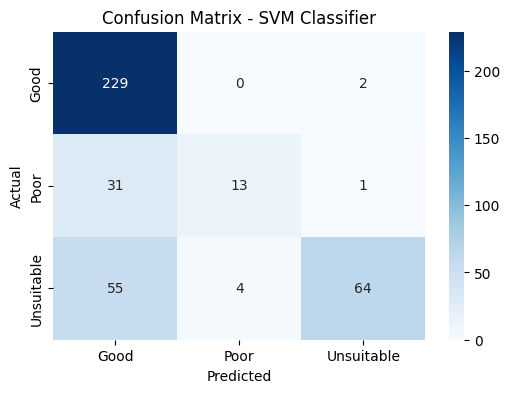

In [ ]:
# SVM MODEL

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Feature matrix and label encoding
X = df[['Dissolved_Oxygen', 'pH', 'Conductivity', 'Biological_Oxygen', 'Nitrate', 'Fecal_Coliform', 'Total_Coliform']]
y = df['WQI_Class'].astype('category')
y_encoded = y.cat.codes
label_names = y.cat.categories.tolist()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SVM Classifier
svm_clf = SVC(kernel='rbf', random_state=42)  # You can change kernel to 'linear', 'poly', 'sigmoid'
svm_clf.fit(X_train, y_train)

# Predictions
y_pred = svm_clf.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Manual Metric Calculation
n_classes = conf_matrix.shape[0]
TP = np.diag(conf_matrix)
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (TP + FP + FN)

# Precision, Recall, F1 for each class
precision_per_class = TP / (TP + FP)
recall_per_class = TP / (TP + FN)
f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)

# Handle division by zero
precision_per_class = np.nan_to_num(precision_per_class)
recall_per_class = np.nan_to_num(recall_per_class)
f1_per_class = np.nan_to_num(f1_per_class)

# Macro averages
precision_macro = precision_per_class.mean()
recall_macro = recall_per_class.mean()
f1_macro = f1_per_class.mean()

# Overall Accuracy
accuracy = (TP.sum()) / conf_matrix.sum()

# Classification Report
report = classification_report(y_test, y_pred, target_names=label_names, zero_division=1)

# Print Evaluation Metrics
print("\nSVM Classifier Model Performance (Manual Calculation):")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall (macro): {recall_macro:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")

print("\nClassification Report (sklearn):\n", report)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM Classifier')
plt.show()


ENSEMBLING

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:13:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:13:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:14:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:14:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Bagged Decision Tree Performance:
Accuracy: 97.99%
Precision (Macro): 0.9675
Recall (Macro): 0.9595
F1 Score (Macro): 0.9634

Classification Report:
              precision    recall  f1-score   support

        Good       0.99      1.00      0.99       231
        Poor       0.93      0.91      0.92        45
  Unsuitable       0.98      0.97      0.98       123

    accuracy                           0.98       399
   macro avg       0.97      0.96      0.96       399
weighted avg       0.98      0.98      0.98       399



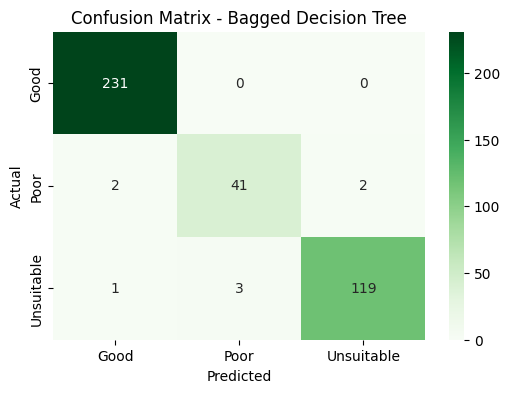


Bagged Random Forest Performance:
Accuracy: 97.99%
Precision (Macro): 0.9733
Recall (Macro): 0.9595
F1 Score (Macro): 0.9662

Classification Report:
              precision    recall  f1-score   support

        Good       0.98      1.00      0.99       231
        Poor       0.95      0.91      0.93        45
  Unsuitable       0.98      0.97      0.98       123

    accuracy                           0.98       399
   macro avg       0.97      0.96      0.97       399
weighted avg       0.98      0.98      0.98       399



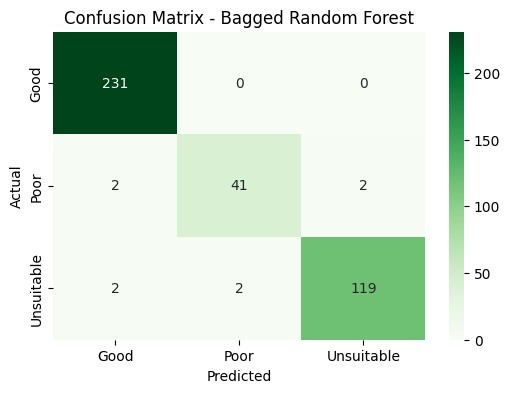


Bagged XGBoost Performance:
Accuracy: 98.25%
Precision (Macro): 0.9797
Recall (Macro): 0.9622
F1 Score (Macro): 0.9706

Classification Report:
              precision    recall  f1-score   support

        Good       0.99      1.00      0.99       231
        Poor       0.98      0.91      0.94        45
  Unsuitable       0.98      0.98      0.98       123

    accuracy                           0.98       399
   macro avg       0.98      0.96      0.97       399
weighted avg       0.98      0.98      0.98       399



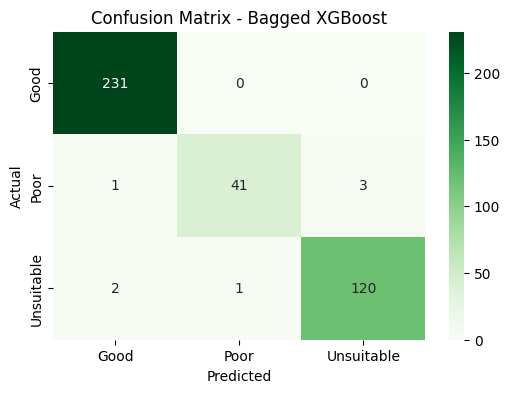

In [ ]:
#Bagging Ensemble with Decision Tree, Random Forest, XGBoost

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Prepare dataset
X = df[numeric_columns]
y_class = df['WQI_Class']

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_class)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Base Models
base_dt = DecisionTreeClassifier(random_state=42)
base_rf = RandomForestClassifier(random_state=42)
base_xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Bagging Models
bagged_dt = BaggingClassifier(estimator=base_dt, n_estimators=50, random_state=42)
bagged_rf = BaggingClassifier(estimator=base_rf, n_estimators=10, random_state=42)
bagged_xgb = BaggingClassifier(estimator=base_xgb, n_estimators=10, random_state=42)

# Train Models
bagged_dt.fit(X_train, y_train)
bagged_rf.fit(X_train, y_train)
bagged_xgb.fit(X_train, y_train)

# Predictions
y_pred_dt = bagged_dt.predict(X_test)
y_pred_rf = bagged_rf.predict(X_test)
y_pred_xgb = bagged_xgb.predict(X_test)

# Evaluation Function
def evaluate_model(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    TP = np.diag(cm)
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP

    precision_per_class = np.nan_to_num(TP / (TP + FP))
    recall_per_class = np.nan_to_num(TP / (TP + FN))
    f1_per_class = np.nan_to_num(2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class))

    precision_macro = precision_per_class.mean()
    recall_macro = recall_per_class.mean()
    f1_macro = f1_per_class.mean()
    accuracy = TP.sum() / cm.sum()

    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Precision (Macro): {precision_macro:.4f}")
    print(f"Recall (Macro): {recall_macro:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Evaluate each Bagging Model
evaluate_model(y_test, y_pred_dt, "Bagged Decision Tree")
evaluate_model(y_test, y_pred_rf, "Bagged Random Forest")
evaluate_model(y_test, y_pred_xgb, "Bagged XGBoost")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:45:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



AdaBoost Performance:
Accuracy: 89.97%
Precision (macro): 0.8557
Recall (macro): 0.8087
F1 Score (macro): 0.8288

Classification Report:
              precision    recall  f1-score   support

        Good       0.90      0.98      0.94       231
        Poor       0.70      0.58      0.63        45
  Unsuitable       0.96      0.87      0.91       123

    accuracy                           0.90       399
   macro avg       0.86      0.81      0.83       399
weighted avg       0.90      0.90      0.90       399



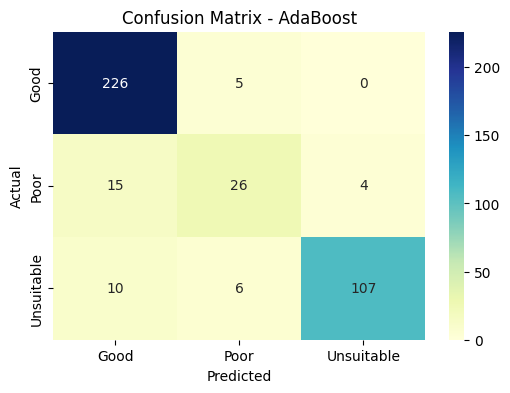


Gradient Boosting Performance:
Accuracy: 97.74%
Precision (macro): 0.9643
Recall (macro): 0.9521
F1 Score (macro): 0.9580

Classification Report:
              precision    recall  f1-score   support

        Good       0.99      1.00      0.99       231
        Poor       0.93      0.89      0.91        45
  Unsuitable       0.98      0.97      0.97       123

    accuracy                           0.98       399
   macro avg       0.96      0.95      0.96       399
weighted avg       0.98      0.98      0.98       399



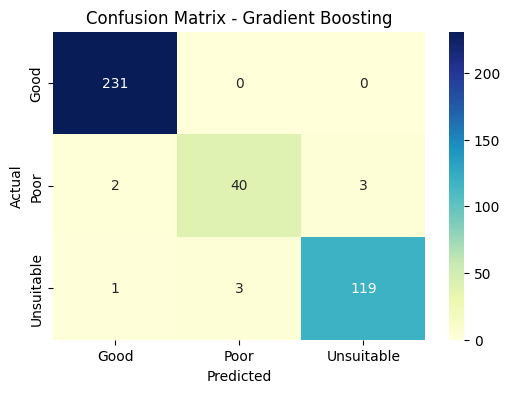


XGBoost Performance:
Accuracy: 97.99%
Precision (macro): 0.9733
Recall (macro): 0.9595
F1 Score (macro): 0.9662

Classification Report:
              precision    recall  f1-score   support

        Good       0.98      1.00      0.99       231
        Poor       0.95      0.91      0.93        45
  Unsuitable       0.98      0.97      0.98       123

    accuracy                           0.98       399
   macro avg       0.97      0.96      0.97       399
weighted avg       0.98      0.98      0.98       399



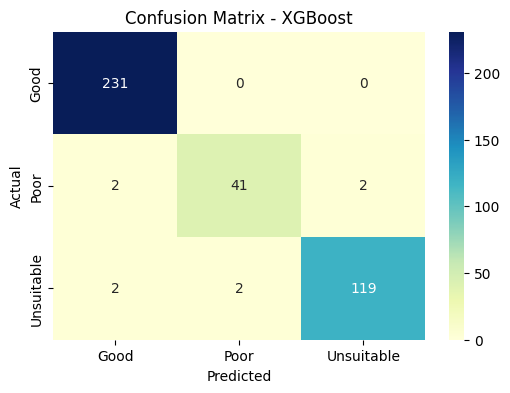

In [ ]:
#boosting - Adaboost, Gradient boost and XGboost
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prepare data
X = df[numeric_columns]
y = df['WQI_Class']  # Ensure this is multi-class

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Boosting models
ada = AdaBoostClassifier(n_estimators=50, random_state=42)
grad = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False,
                    eval_metric='mlogloss', random_state=42)

# Fit models
ada.fit(X_train, y_train)
grad.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Predict
y_pred_ada = ada.predict(X_test)
y_pred_grad = grad.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

# Multi-class evaluation
def evaluate_multiclass(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    TP = np.diag(cm)
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)

    precision = np.nan_to_num(precision)
    recall = np.nan_to_num(recall)
    f1 = np.nan_to_num(f1)

    accuracy = TP.sum() / cm.sum()
    precision_macro = precision.mean()
    recall_macro = recall.mean()
    f1_macro = f1.mean()

    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Precision (macro): {precision_macro:.4f}")
    print(f"Recall (macro): {recall_macro:.4f}")
    print(f"F1 Score (macro): {f1_macro:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))

    # Confusion matrix heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Evaluate
evaluate_multiclass(y_test, y_pred_ada, "AdaBoost")
evaluate_multiclass(y_test, y_pred_grad, "Gradient Boosting")
evaluate_multiclass(y_test, y_pred_xgb, "XGBoost")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:55:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:55:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:55:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:55:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:55:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Stacking Classifier Model Performance (Modified Version):
Accuracy: 98.25%
Precision: 0.9748
Recall (Sensitivity): 0.9622
F1 Score: 0.9683

Classification Report:
               precision    recall  f1-score   support

        Good       0.99      1.00      0.99       231
        Poor       0.95      0.91      0.93        45
  Unsuitable       0.98      0.98      0.98       123

    accuracy                           0.98       399
   macro avg       0.97      0.96      0.97       399
weighted avg       0.98      0.98      0.98       399



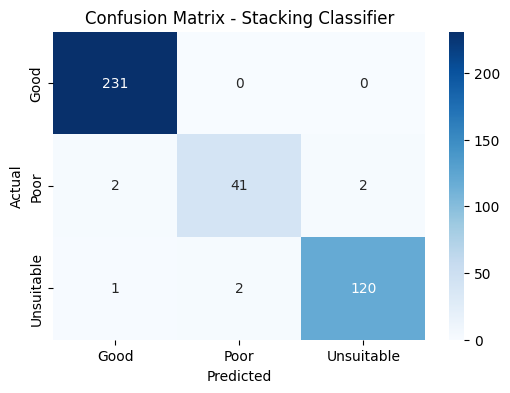

In [ ]:
# STACKING

import warnings
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress XGBoost warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*use_label_encoder.*")

# Feature matrix and label encoding
X = df[['Dissolved_Oxygen', 'pH', 'Conductivity', 'Biological_Oxygen', 'Nitrate', 'Fecal_Coliform', 'Total_Coliform']]
y = df['WQI_Class'].astype('category')
y_encoded = y.cat.codes
label_names = y.cat.categories.tolist()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Base models for stacking (SVM, Random Forest, and XGBoost)
base_learners = [
    ('svm', SVC(kernel='rbf', probability=True, random_state=42)),  # SVM Classifier
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),  # Random Forest Classifier
    ('xgb', XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False))  # XGBoost Classifier
]

# Meta-model (Logistic Regression)
meta_model = LogisticRegression(random_state=42)

# Stacking Classifier
stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_model)

# Train stacking model
stacking_clf.fit(X_train, y_train)

# Predictions
y_pred = stacking_clf.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Accuracy (overall)
accuracy = accuracy_score(y_test, y_pred) * 100

# Precision, Recall, F1 Score (macro average for multi-class classification)
precision = precision_score(y_test, y_pred, average='macro', zero_division=1)
recall = recall_score(y_test, y_pred, average='macro', zero_division=1)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=1)

# Classification Report
report = classification_report(y_test, y_pred, target_names=label_names, zero_division=1)

# Print Evaluation Metrics
print("Stacking Classifier Model Performance (Modified Version):")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n", report)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Stacking Classifier')
plt.show()


100%|██████████| 30/30 [14:35<00:00, 29.17s/trial, best loss: -0.9685901763612029]

--- Stacking Classifier Model Performance (Fast Bayesian Optimized) ---
Accuracy           : 97.24%
Precision (macro)  : 0.9531
Recall (macro)     : 0.9516
F1 Score (macro)   : 0.9521

--- Classification Report ---
              precision    recall  f1-score   support

        Good       0.98      1.00      0.99       235
        Poor       0.89      0.91      0.90        44
  Unsuitable       0.99      0.95      0.97       120

    accuracy                           0.97       399
   macro avg       0.95      0.95      0.95       399
weighted avg       0.97      0.97      0.97       399



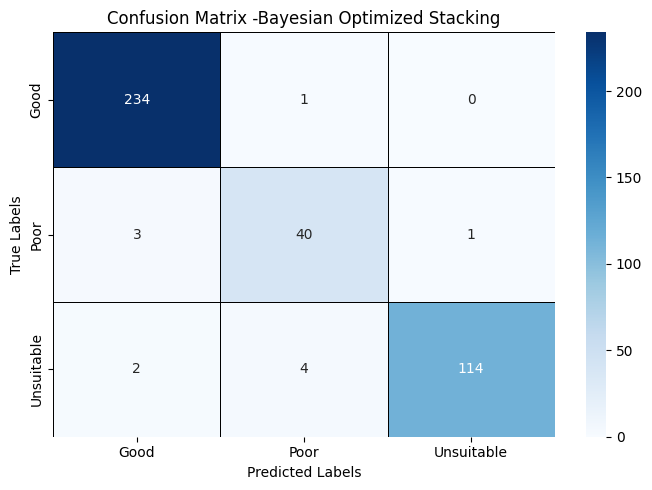

In [ ]:
#Bayesian Optimized Stacking
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

warnings.filterwarnings("ignore")

# Feature matrix and label encoding
X = df[['Dissolved_Oxygen', 'pH', 'Conductivity', 'Biological_Oxygen', 'Nitrate', 'Fecal_Coliform', 'Total_Coliform']]
y = df['WQI_Class'].astype('category')
y_encoded = y.cat.codes
label_names = y.cat.categories.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Objective function (fast)
def objective(params):
    rf = RandomForestClassifier(
        n_estimators=int(params['rf_n_estimators']),
        max_depth=int(params['rf_max_depth']),
        random_state=42
    )
    xgb = XGBClassifier(
        n_estimators=int(params['xgb_n_estimators']),
        max_depth=int(params['xgb_max_depth']),
        learning_rate=params['xgb_learning_rate'],
        use_label_encoder=False,
        verbosity=0,
        random_state=42
    )
    et = ExtraTreesClassifier(
        n_estimators=int(params['et_n_estimators']),
        max_depth=int(params['et_max_depth']),
        random_state=42
    )
    gb = GradientBoostingClassifier(
        n_estimators=int(params['gb_n_estimators']),
        max_depth=int(params['gb_max_depth']),
        learning_rate=params['gb_learning_rate'],
        random_state=42
    )
    meta_model = LogisticRegression(
        C=params['meta_C'],
        max_iter=1000,
        random_state=42
    )

    stacking_clf = StackingClassifier(
        estimators=[('rf', rf), ('xgb', xgb), ('et', et), ('gb', gb)],
        final_estimator=meta_model,
        n_jobs=-1
    )

    score = cross_val_score(stacking_clf, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1).mean()
    return {'loss': -score, 'status': STATUS_OK}

# Search space (smaller models)
space = {
    'rf_n_estimators': hp.quniform('rf_n_estimators', 50, 150, 10),
    'rf_max_depth': hp.quniform('rf_max_depth', 5, 15, 2),
    'xgb_n_estimators': hp.quniform('xgb_n_estimators', 50, 150, 10),
    'xgb_max_depth': hp.quniform('xgb_max_depth', 3, 8, 1),
    'xgb_learning_rate': hp.uniform('xgb_learning_rate', 0.05, 0.2),
    'et_n_estimators': hp.quniform('et_n_estimators', 50, 150, 10),
    'et_max_depth': hp.quniform('et_max_depth', 5, 15, 2),
    'gb_n_estimators': hp.quniform('gb_n_estimators', 50, 150, 10),
    'gb_max_depth': hp.quniform('gb_max_depth', 3, 7, 1),
    'gb_learning_rate': hp.uniform('gb_learning_rate', 0.05, 0.2),
    'meta_C': hp.uniform('meta_C', 0.1, 2.0)
}

# Run Bayesian Optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=30, trials=trials, rstate=np.random.default_rng(42))

# Train final models (full size)
rf_best = RandomForestClassifier(
    n_estimators=int(best['rf_n_estimators']) * 2,
    max_depth=int(best['rf_max_depth']),
    random_state=42
)

xgb_best = XGBClassifier(
    n_estimators=int(best['xgb_n_estimators']) * 2,
    max_depth=int(best['xgb_max_depth']),
    learning_rate=best['xgb_learning_rate'],
    use_label_encoder=False,
    verbosity=0,
    random_state=42
)

et_best = ExtraTreesClassifier(
    n_estimators=int(best['et_n_estimators']) * 2,
    max_depth=int(best['et_max_depth']),
    random_state=42
)

gb_best = GradientBoostingClassifier(
    n_estimators=int(best['gb_n_estimators']) * 2,
    max_depth=int(best['gb_max_depth']),
    learning_rate=best['gb_learning_rate'],
    random_state=42
)

meta_model = LogisticRegression(
    C=best['meta_C'],
    max_iter=1000,
    random_state=42
)

# Final Stacking Classifier
stacking_clf_final = StackingClassifier(
    estimators=[('rf', rf_best), ('xgb', xgb_best), ('et', et_best), ('gb', gb_best)],
    final_estimator=meta_model,
    n_jobs=-1
)

stacking_clf_final.fit(X_train, y_train)
y_pred = stacking_clf_final.predict(X_test)

# Evaluation
conf_matrix = confusion_matrix(y_test, y_pred)
TP = np.diag(conf_matrix)
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP

epsilon = 1e-9
precision_per_class = TP / (TP + FP + epsilon)
recall_per_class = TP / (TP + FN + epsilon)
f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class + epsilon)

precision_macro = np.mean(precision_per_class)
recall_macro = np.mean(recall_per_class)
f1_macro = np.mean(f1_per_class)
accuracy = TP.sum() / conf_matrix.sum()

# Print Results
print("\n--- Stacking Classifier Model Performance (Fast Bayesian Optimized) ---")
print(f"Accuracy           : {accuracy * 100:.2f}%")
print(f"Precision (macro)  : {precision_macro:.4f}")
print(f"Recall (macro)     : {recall_macro:.4f}")
print(f"F1 Score (macro)   : {f1_macro:.4f}")

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=label_names, zero_division=1))

# Plot Confusion Matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names, linewidths=0.5, linecolor='black')
plt.title('Confusion Matrix -Bayesian Optimized Stacking')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


Fitting 2 folds for each of 576 candidates, totalling 1152 fits

Best Hyperparameters from Grid Search:
{'final_estimator__C': 0.5, 'rf__max_depth': 10, 'rf__n_estimators': 100, 'svm__C': 0.5, 'svm__gamma': 'auto', 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 150}

--- Final Stacking Classifier Performance (Manual Calculation) ---
Accuracy          : 97.24%
Precision (macro) : 0.9516
Recall (macro)    : 0.9516
F1 Score (macro)  : 0.9515

--- Classification Report (Sklearn) ---

              precision    recall  f1-score   support

        Good       0.98      1.00      0.99       235
        Poor       0.89      0.91      0.90        44
  Unsuitable       0.98      0.95      0.97       120

    accuracy                           0.97       399
   macro avg       0.95      0.95      0.95       399
weighted avg       0.97      0.97      0.97       399



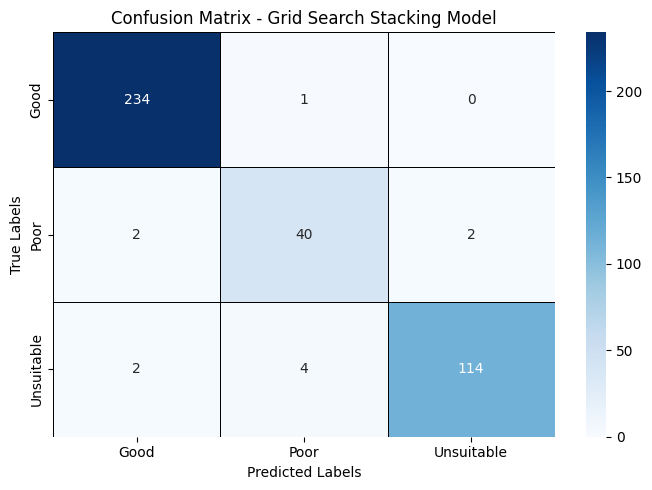

In [ ]:
# GridSearch Optimized Stacking
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# Suppress warnings
warnings.filterwarnings('ignore')

# Prepare Data
X = df[['Dissolved_Oxygen', 'pH', 'Conductivity', 'Biological_Oxygen', 'Nitrate', 'Fecal_Coliform', 'Total_Coliform']]
y = df['WQI_Class'].astype('category')
y_encoded = y.cat.codes
label_names = y.cat.categories.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Define base models
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42, use_label_encoder=False, verbosity=0)
svm = SVC(probability=True, random_state=42)

# StackingClassifier
stacking_model = StackingClassifier(
    estimators=[
        ('rf', rf),
        ('xgb', xgb),
        ('svm', svm)
    ],
    final_estimator=LogisticRegression(random_state=42),
    n_jobs=-1
)

# Define parameter grid
param_grid = {
    'rf__n_estimators': [100, 150],
    'rf__max_depth': [5, 10],
    'xgb__n_estimators': [100, 150],
    'xgb__max_depth': [3, 5],
    'xgb__learning_rate': [0.05, 0.1],
    'svm__C': [0.5, 1, 10],
    'svm__gamma': ['scale', 'auto'],
    'final_estimator__C': [0.5, 1.0, 5.0]
}

# GridSearchCV
grid_search = GridSearchCV(estimator=stacking_model,
                           param_grid=param_grid,
                           cv=2,                   # 2 folds to speed up
                           scoring='accuracy',
                           verbose=2,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

# Best parameters
print("\nBest Hyperparameters from Grid Search:")
print(grid_search.best_params_)

# Predict using best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Manual Metric Calculation
n_classes = conf_matrix.shape[0]
TP = np.diag(conf_matrix)
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (TP + FP + FN)

precision_per_class = np.divide(TP, TP + FP, out=np.zeros_like(TP, dtype=float), where=(TP+FP)!=0)
recall_per_class = np.divide(TP, TP + FN, out=np.zeros_like(TP, dtype=float), where=(TP+FN)!=0)
f1_per_class = np.divide(2 * precision_per_class * recall_per_class,
                         precision_per_class + recall_per_class,
                         out=np.zeros_like(precision_per_class, dtype=float),
                         where=(precision_per_class + recall_per_class)!=0)

precision_macro = precision_per_class.mean()
recall_macro = recall_per_class.mean()
f1_macro = f1_per_class.mean()

accuracy = TP.sum() / conf_matrix.sum()

# Classification Report
report = classification_report(y_test, y_pred, target_names=label_names, zero_division=1)

# Print Results
print("\n--- Final Stacking Classifier Performance (Manual Calculation) ---")
print(f"Accuracy          : {accuracy * 100:.2f}%")
print(f"Precision (macro) : {precision_macro:.4f}")
print(f"Recall (macro)    : {recall_macro:.4f}")
print(f"F1 Score (macro)  : {f1_macro:.4f}")

print("\n--- Classification Report (Sklearn) ---\n")
print(report)

# Plot Confusion Matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names, linewidths=0.5, linecolor='black')
plt.title('Confusion Matrix - Grid Search Stacking Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


Fitting 2 folds for each of 20 candidates, totalling 40 fits

Best Hyperparameters from Random Search:
{'final_estimator__C': np.float64(0.7089971816088135), 'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__n_estimators': 64, 'xgb__colsample_bytree': np.float64(0.9266653415629146), 'xgb__learning_rate': np.float64(0.08431972482374336), 'xgb__max_depth': 5, 'xgb__n_estimators': 135, 'xgb__subsample': np.float64(0.9641403517045772)}

--- Final Stacking Classifier Performance (Manual Calculation) ---
Accuracy          : 97.24%
Precision (macro) : 0.9531
Recall (macro)    : 0.9516
F1 Score (macro)  : 0.9521

--- Classification Report (Sklearn) ---

              precision    recall  f1-score   support

        Good       0.98      1.00      0.99       235
        Poor       0.89      0.91      0.90        44
  Unsuitable       0.99      0.95      0.97       120

    accuracy                           0.97       399
   macro avg       0.95      0.95      0.95       399
weighted avg  

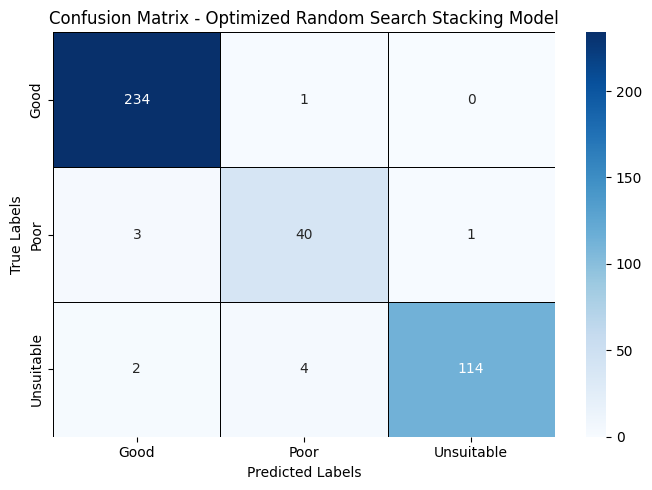

In [ ]:
# RANDOM SEARCH on stacking

import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import randint, uniform

warnings.filterwarnings('ignore')

# Prepare Data
X = df[['Dissolved_Oxygen', 'pH', 'Conductivity', 'Biological_Oxygen', 'Nitrate', 'Fecal_Coliform', 'Total_Coliform']]
y = df['WQI_Class'].astype('category')
y_encoded = y.cat.codes
label_names = y.cat.categories.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Define base models (no SVM this time for speed)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42, use_label_encoder=False, verbosity=0)

# StackingClassifier
stacking_model = StackingClassifier(
    estimators=[
        ('rf', rf),
        ('xgb', xgb)
    ],
    final_estimator=LogisticRegression(random_state=42),
    n_jobs=-1
)

# Define search space
param_dist = {
    'rf__n_estimators': randint(50, 150),          # Reduced range
    'rf__max_depth': [5, 10, None],                 # Limited options
    'rf__max_features': ['sqrt', 'log2'],           # Add feature sampling
    'xgb__n_estimators': randint(50, 150),
    'xgb__max_depth': randint(3, 8),
    'xgb__learning_rate': uniform(0.05, 0.15),      # Learning rates between 0.05–0.2
    'xgb__subsample': uniform(0.7, 0.3),            # Enable sampling
    'xgb__colsample_bytree': uniform(0.7, 0.3),
    'final_estimator__C': uniform(0.5, 1.5)         # Tighter range
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=stacking_model,
    param_distributions=param_dist,
    n_iter=20,                        # Reduced to 20 for faster run
    cv=2,                             # 2-fold CV instead of 3
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy'
)

random_search.fit(X_train, y_train)

# Best parameters
print("\nBest Hyperparameters from Random Search:")
print(random_search.best_params_)

# Predict
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Manual Metric Calculation
n_classes = conf_matrix.shape[0]
TP = np.diag(conf_matrix)
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (TP + FP + FN)

precision_per_class = np.divide(TP, TP + FP, out=np.zeros_like(TP, dtype=float), where=(TP+FP)!=0)
recall_per_class = np.divide(TP, TP + FN, out=np.zeros_like(TP, dtype=float), where=(TP+FN)!=0)
f1_per_class = np.divide(2 * precision_per_class * recall_per_class,
                         precision_per_class + recall_per_class,
                         out=np.zeros_like(precision_per_class, dtype=float),
                         where=(precision_per_class + recall_per_class)!=0)

precision_macro = precision_per_class.mean()
recall_macro = recall_per_class.mean()
f1_macro = f1_per_class.mean()

accuracy = TP.sum() / conf_matrix.sum()

# Report
report = classification_report(y_test, y_pred, target_names=label_names, zero_division=1)

print("\n--- Final Stacking Classifier Performance (Manual Calculation) ---")
print(f"Accuracy          : {accuracy * 100:.2f}%")
print(f"Precision (macro) : {precision_macro:.4f}")
print(f"Recall (macro)    : {recall_macro:.4f}")
print(f"F1 Score (macro)  : {f1_macro:.4f}")

print("\n--- Classification Report (Sklearn) ---\n")
print(report)

# Plot Confusion Matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names, linewidths=0.5, linecolor='black')
plt.title('Confusion Matrix - Optimized Random Search Stacking Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#Generate 10 Random Samples
random_samples = pd.DataFrame({
    'Dissolved_Oxygen': np.random.uniform(1.0, 14.6, 10),
    'pH': np.random.uniform(6.0, 8.5, 10),
    'Conductivity': np.random.uniform(50, 1500, 10),
    'Biological_Oxygen': np.random.uniform(1.0, 10.0, 10),
    'Nitrate': np.random.uniform(0.0, 45.0, 10),
    'Fecal_Coliform': np.random.uniform(0, 2500, 10),
    'Total_Coliform': np.random.uniform(0, 3000, 10)
})

#Define WQI Calculation
standards = {
    'Dissolved_Oxygen': (14.6, 6),
    'pH': (8.5, 7),
    'Conductivity': (300, 0),
    'Biological_Oxygen': (5, 0),
    'Nitrate': (45, 0),
    'Fecal_Coliform': (500, 0),
    'Total_Coliform': (1000, 0)
}

weights = {param: 1/std[0] for param, std in standards.items()}

def compute_qi(value, param):
    si, vid = standards[param]
    return ((value - vid) / (si - vid)) * 100 if pd.notna(value) else 0

def classify_wqi(wqi):
    if wqi <= 50:
        return "Good"
    elif 51 <= wqi <= 100:
        return "Poor"
    else:
        return "Unsuitable"

#Compute WQI and Class
random_samples['WQI'] = random_samples.apply(
    lambda row: sum(compute_qi(row[param], param) * weights[param] for param in standards.keys()) / sum(weights.values()),
    axis=1
)
random_samples['Calculated_WQI_Class'] = random_samples['WQI'].apply(classify_wqi)

#Encode Actual Class
label_names = ["Good", "Poor", "Unsuitable"]  # make sure this matches your model's labels
actual_labels = random_samples['Calculated_WQI_Class'].map({name: i for i, name in enumerate(label_names)})

#Predict with Stacking Model
predicted_class_indices = stacking_clf.predict(random_samples[numeric_columns])
random_samples['Predicted_WQI_Class'] = [label_names[i] for i in predicted_class_indices]

#Evaluation Metrics
acc = accuracy_score(actual_labels, predicted_class_indices)
prec = precision_score(actual_labels, predicted_class_indices, average='macro', zero_division=1)
rec = recall_score(actual_labels, predicted_class_indices, average='macro', zero_division=1)
f1 = f1_score(actual_labels, predicted_class_indices, average='macro', zero_division=1)
conf_matrix = confusion_matrix(actual_labels, predicted_class_indices)

#Display Results
print("\nRandom Sample Predictions:\n")
print(random_samples[['Dissolved_Oxygen', 'pH', 'Conductivity', 'Biological_Oxygen',
                      'Nitrate', 'Fecal_Coliform', 'Total_Coliform', 'WQI',
                      'Calculated_WQI_Class', 'Predicted_WQI_Class']])

print("\nEvaluation on Random Samples:")
print(f"Accuracy: {acc * 100:.2f}%")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

#Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()


NameError: name 'stacking_clf' is not defined

In [ ]:
pip install scikit-learn matplotlib seaborn xgboost





/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:14:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:14:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:14:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:14:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:14:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

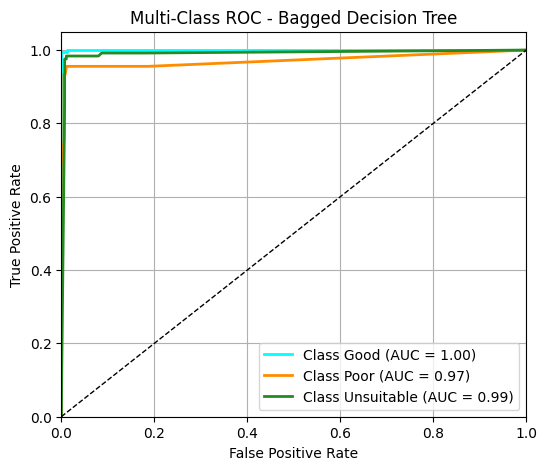

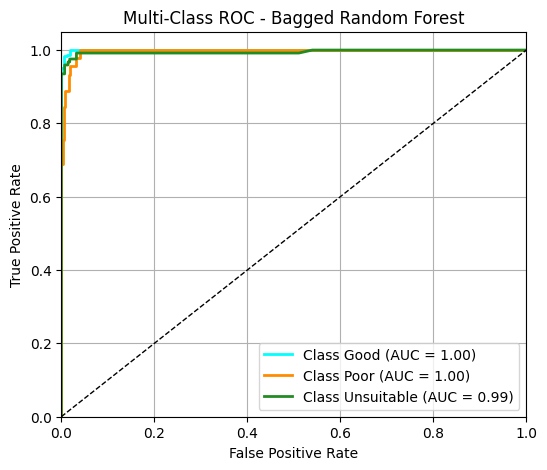

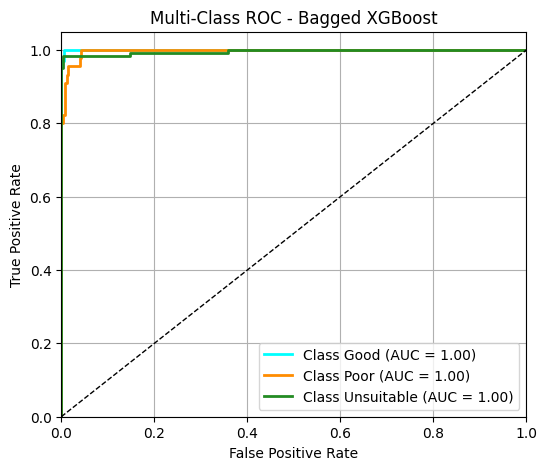

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarize the test labels for ROC computation
y_test_bin = label_binarize(y_test, classes=np.unique(y_encoded))
n_classes = y_test_bin.shape[1]

# Wrap bagged models with OneVsRestClassifier
dt_ovr = OneVsRestClassifier(bagged_dt).fit(X_train, label_binarize(y_train, classes=np.unique(y_encoded)))
rf_ovr = OneVsRestClassifier(bagged_rf).fit(X_train, label_binarize(y_train, classes=np.unique(y_encoded)))
xgb_ovr = OneVsRestClassifier(bagged_xgb).fit(X_train, label_binarize(y_train, classes=np.unique(y_encoded)))

# Predict probabilities
y_score_dt = dt_ovr.predict_proba(X_test)
y_score_rf = rf_ovr.predict_proba(X_test)
y_score_xgb = xgb_ovr.predict_proba(X_test)

# Function to plot ROC curve
def plot_roc_curves(y_test_bin, y_score, model_name):
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(6, 5))
    colors = cycle(['aqua', 'darkorange', 'forestgreen', 'blue', 'red'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multi-Class ROC - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Plot ROC for all models
plot_roc_curves(y_test_bin, y_score_dt, "Bagged Decision Tree")
plot_roc_curves(y_test_bin, y_score_rf, "Bagged Random Forest")
plot_roc_curves(y_test_bin, y_score_xgb, "Bagged XGBoost")


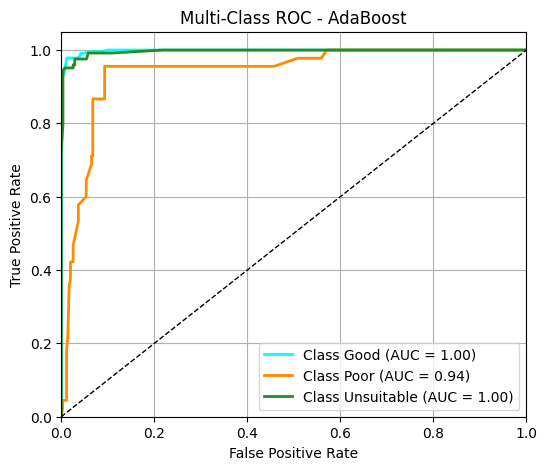

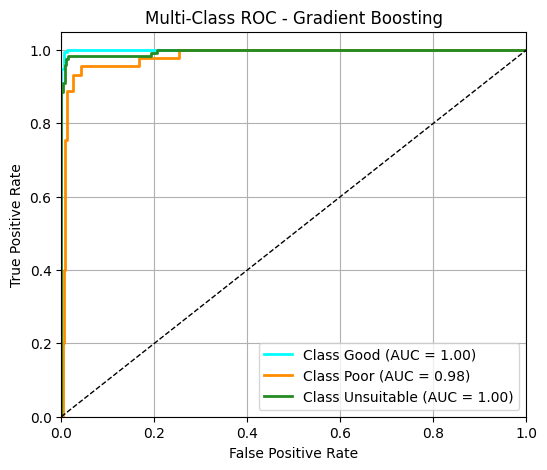

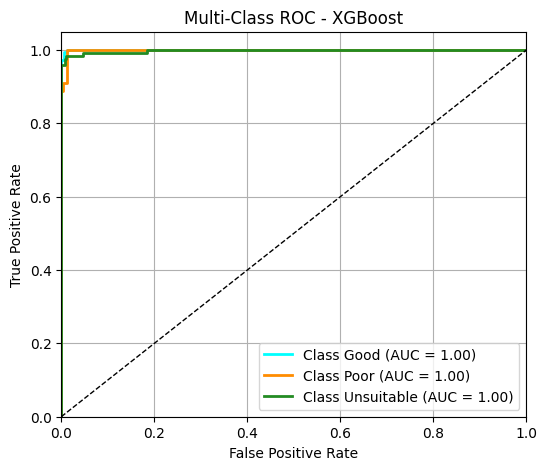

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarize labels
y_train_bin = label_binarize(y_train, classes=np.unique(y_encoded))
y_test_bin = label_binarize(y_test, classes=np.unique(y_encoded))
n_classes = y_test_bin.shape[1]

# AdaBoost and Gradient Boosting with OneVsRest
ada_ovr = OneVsRestClassifier(AdaBoostClassifier(n_estimators=50, random_state=42))
grad_ovr = OneVsRestClassifier(GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42))

ada_ovr.fit(X_train, y_train_bin)
grad_ovr.fit(X_train, y_train_bin)

# XGBoost - train normally on original y
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)

# Predict probabilities
y_score_ada = ada_ovr.predict_proba(X_test)
y_score_grad = grad_ovr.predict_proba(X_test)
y_score_xgb = xgb.predict_proba(X_test)  # already returns shape [n_samples, n_classes]

# ROC plotting function
def plot_roc_curves(y_test_bin, y_score, model_name):
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(6, 5))
    colors = cycle(['aqua', 'darkorange', 'forestgreen', 'blue', 'red'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multi-Class ROC - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Plot ROC for each model
plot_roc_curves(y_test_bin, y_score_ada, "AdaBoost")
plot_roc_curves(y_test_bin, y_score_grad, "Gradient Boosting")
plot_roc_curves(y_test_bin, y_score_xgb, "XGBoost")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:09:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:09:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:09:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:09:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:09:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

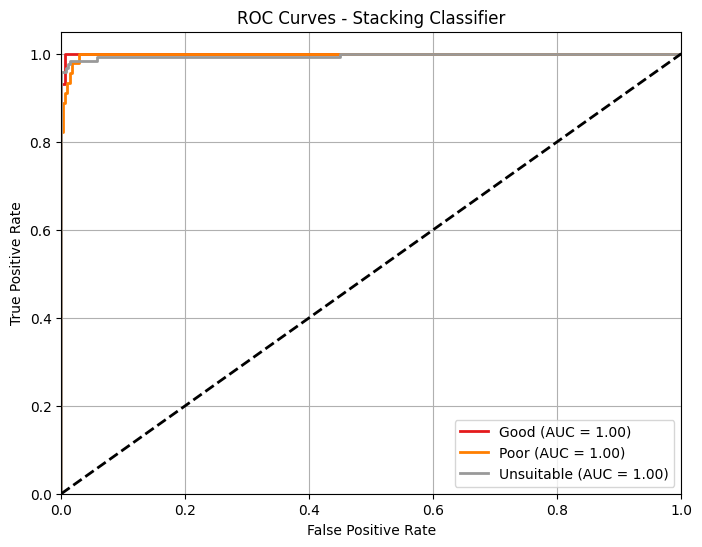

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np

# Binarize the labels
y_bin = label_binarize(y_encoded, classes=np.unique(y_encoded))
n_classes = y_bin.shape[1]

# Standardize input features (especially helps for SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data again using scaled inputs
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)
y_test_bin = label_binarize(y_test, classes=np.unique(y_encoded))

# Wrap the stacking classifier with OneVsRestClassifier for multi-class ROC
stacking_ovr = OneVsRestClassifier(
    StackingClassifier(estimators=base_learners, final_estimator=meta_model)
)
stacking_ovr.fit(X_train, label_binarize(y_train, classes=np.unique(y_encoded)))

# Predict probabilities for ROC
y_score = stacking_ovr.predict_proba(X_test)

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap('Set1', n_classes)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{label_names[i]} (AUC = {roc_auc[i]:.2f})', color=colors(i))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Stacking Classifier')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
